<a href="https://colab.research.google.com/github/hueglijoshua/CVI03.HS24-Computer-Vision/blob/main/04a_YOLO_object_detection_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import yaml
import numpy as np
from datetime import datetime
import shutil
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.lines as mlines

# Obejct detection using YOLO bounding boxes

This notebooks aims in finding the best model for the object detection using YOLO. In a second notebook the best model will then be applied on our test data.

For the task of finding the best model, we use only the imagaes containing fracture.

First we are going to install the ultralöytics package, which offers easy implementation of difference YOLO models.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/data_object_detection_yolo"

# Verify the dataset structure
os.listdir(dataset_path)

['data.yaml', 'images', 'labels', 'classes.txt', 'hyp.yaml']

Several hyperparameters can be defined for our model. We set the warmup epochs to 3 and we set the values for data augmentation for hue, saturation and brightness. No rotation or shear should be introduced, but the vertical or horizontal flip probability are set to 0.5 and we also set the scale augmentation to 0.5. Below the several different options, including the selected ones, are shown.

In [ ]:
# Define the hyperparameters
hyp_params = {
    # "lr0": 0.01,        # Initial learning rate
    # "lrf": 0.001,         # Final learning rate
    # "momentum": 0.937,  # SGD momentum
    # "weight_decay": 0.0005,  # Regularization
    "warmup_epochs": 3.0,   # Warmup period
    # "warmup_momentum": 0.8,
    # "warmup_bias_lr": 0.1,
    # "box": 0.05,  # Box loss gain
    # "cls": 0.5,   # Classification loss gain
    # "cls_pw": 1.0,  # Class label smoothing
    # "obj": 1.0,  # Object loss gain
    # "obj_pw": 1.0,
    # "iou_t": 0.2,  # IoU training threshold
    # "anchor_t": 4.0,  # Anchor-matching threshold
    # "fl_gamma": 0.0,  # Focal loss gamma (if > 0, Focal Loss is used)
    "hsv_h": 0.015,  # Hue augmentation
    "hsv_s": 0.7,    # Saturation augmentation
    "hsv_v": 0.4,    # Brightness augmentation
    "degrees": 0.0,  # Rotation augmentation
    # "translate": 0.1,  # Translation augmentation
    "scale": 0.5,  # Scale augmentation
    "shear": 0.0,  # Shear augmentation
    # "perspective": 0.001,  # Perspective distortion
    "flipud": 0.5,  # Vertical flip probability
    "fliplr": 0.5,  # Horizontal flip probability
    # "mosaic": 1.0,  # Mosaic augmentation probability
    # "mixup": 0.1,  # Mixup augmentation probability
    # "copy_paste": 0.0,  # Copy-paste augmentation
}

### **Model Training Loop Description**
In this section, we iterate through different configurations of YOLO models to systematically train and evaluate their performance. The training loop consists of the following steps:

1. **Loop through YOLO model versions**  
   - We consider different versions of the YOLO model_ YOLOv8 and YOLOv11.
   - YOLO v8 is a widely used version of while v11 is the newest version.
   
2. **Loop through model sizes**  
   - Each version comes in multiple sizes: nano (`n`), small (`s`), medium (`m`), large (`l`), and extra-large (`x`).

3. **Loop through freeze levels**  
   - The freeze level determines how many layers of the model remain unchanged during training:
     - `0`: No layers are frozen (full training).
     - `10`: The first 10 layers (= backbone) are frozen.
     - `"all"`: All layers are frozen (only the final layer is trained).

4. **Train the model with the selected parameters**  
   - The dataset configuration is provided.
   - Training runs for a set number of epochs with early stopping (`patience`).
   - The model is trained with validation enabled.
   - Each training run is saved under a structured naming format (`model_comparison/yolo_vXsize_freezeY`).

5. **Save results and model weights**  
   - The best model weights (`best.pt`) are saved to a dedicated directory.  
   - The training results, including performance metrics, are saved in a CSV file (`results.csv`).  
   - Each result file is uniquely named based on the model version, size, and freeze level.

This process allows for a structured comparison of different YOLO model variations, enabling us to analyze their performance under different training conditions.

In [ ]:
# Base directory for saving results
drive_save_dir = "/content/drive/MyDrive/yolo_model_comparison"

# Create the directory if it doesn't exist
os.makedirs(drive_save_dir, exist_ok=True)

# Select model version
versions = [11]
# versions = [8,11]
sizes = ['x']
# sizes = ['n','s','m','l','x']
freeze_levels = [0, 10, "all"]

for ver in versions:
    for size in sizes:
        print(f"v{ver} - size: {size}")
        model = YOLO(f"yolo{ver}{size}.pt")

        model.overrides.update(hyp_params)

        for freeze_val in freeze_levels:
            print(f"Training with freeze={freeze_val}")
            results = model.train(data=f"{dataset_path}/data.yaml",
                                  epochs=200,
                                  imgsz=640,
                                  patience=10,
                                  val = True,
                                  freeze=freeze_val,
                                  project="model_comparison",
                                  name=f"yolo_v{ver}{size}_freeze_{freeze_val}")

            # Define paths
            run_dir = str(model.trainer.save_dir)  # Gets the directory where training results are saved
            best_model_path = os.path.join(run_dir, "weights", "best.pt")
            results_csv_path = os.path.join(run_dir, "results.csv")

            # Save model
            model_filename = f"yolo_v{ver}{size}_freeze{freeze_val}.pt"
            model_save_path = os.path.join(drive_save_dir, model_filename)
            shutil.copy(best_model_path, model_save_path)
            print(f"Saved model yolo_v{ver}{size} with freeze={freeze_val} at: {model_save_path}")

            # Save results CSV
            results_csv_filename = f"results_yolo_v{ver}{size}_freeze{freeze_val}.csv"
            results_csv_save_path = os.path.join(drive_save_dir, results_csv_filename)
            if os.path.exists(results_csv_path):  # Ensure the CSV file exists
                shutil.copy(results_csv_path, results_csv_save_path)
                print(f"Saved results CSV for yolo_v{ver}{size} with freeze={freeze_val} at: {results_csv_save_path}")
            else:
                print(f"Warning: results.csv not found for yolo_v{ver}{size} with freeze={freeze_val}")


v11 - size: x


100%|██████████| 109M/109M [00:01<00:00, 71.3MB/s]


Training with freeze=0
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/drive/MyDrive/data_object_detection_yolo/data.yaml, epochs=200, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=model_comparison, name=yolo_v11x_freeze_0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

100%|██████████| 755k/755k [00:00<00:00, 3.28MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

train: Scanning /content/drive/MyDrive/data_object_detection_yolo/labels/train.cache... 574 images, 0 backgrounds, 0 corrupt: 100%|██████████| 574/574 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/data_object_detection_yolo/labels/val.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]


Plotting labels to model_comparison/yolo_v11x_freeze_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to model_comparison/yolo_v11x_freeze_0
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200         0G      2.868      4.885      2.036         35        640: 100%|██████████| 36/36 [30:05<00:00, 50.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [02:21<00:00, 47.16s/it]

                   all         82         91   0.000285     0.0769   0.000153    2.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200         0G      3.112      3.694      2.163         30        640: 100%|██████████| 36/36 [28:13<00:00, 47.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:07<00:00, 22.57s/it]

                   all         82         91   0.000285     0.0769   0.000153    2.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200         0G      3.118      3.448      2.145         24        640: 100%|██████████| 36/36 [27:44<00:00, 46.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:08<00:00, 23.00s/it]

                   all         82         91   0.000285     0.0769   0.000153    2.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200         0G      3.067      3.341      2.113         28        640: 100%|██████████| 36/36 [28:34<00:00, 47.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:11<00:00, 23.74s/it]

                   all         82         91   0.000285     0.0769   0.000153    2.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200         0G       3.01      3.237      2.072         22        640: 100%|██████████| 36/36 [28:46<00:00, 47.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:12<00:00, 24.08s/it]

                   all         82         91   0.000644      0.143   0.000379   9.51e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200         0G      3.009      3.133       2.06         23        640: 100%|██████████| 36/36 [28:34<00:00, 47.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:09<00:00, 23.27s/it]

                   all         82         91      0.104     0.0989     0.0395    0.00781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200         0G      2.858      3.029       1.97         25        640: 100%|██████████| 36/36 [29:25<00:00, 49.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:13<00:00, 24.56s/it]

                   all         82         91      0.118     0.0989     0.0314    0.00966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200         0G      2.889      3.066      1.968         31        640: 100%|██████████| 36/36 [29:42<00:00, 49.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:17<00:00, 25.87s/it]

                   all         82         91   4.11e-05      0.011   2.06e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200         0G      2.872      2.949      1.968         32        640: 100%|██████████| 36/36 [29:49<00:00, 49.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:14<00:00, 24.88s/it]

                   all         82         91      0.069       0.11     0.0207    0.00659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200         0G      2.835      2.927      1.978         26        640: 100%|██████████| 36/36 [29:32<00:00, 49.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:15<00:00, 25.05s/it]

                   all         82         91      0.283      0.033     0.0258    0.00868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200         0G      2.782      2.831      1.894         34        640: 100%|██████████| 36/36 [29:14<00:00, 48.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:16<00:00, 25.48s/it]

                   all         82         91      0.334       0.11     0.0773     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200         0G      2.739      2.806      1.895         39        640: 100%|██████████| 36/36 [28:37<00:00, 47.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:13<00:00, 24.43s/it]

                   all         82         91      0.143      0.209     0.0857     0.0202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200         0G      2.834      2.881      1.956         42        640: 100%|██████████| 36/36 [29:27<00:00, 49.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:11<00:00, 23.78s/it]

                   all         82         91    0.00609      0.154    0.00906      0.004



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200         0G      2.714      2.813      1.859         26        640: 100%|██████████| 36/36 [29:00<00:00, 48.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:26<00:00, 28.99s/it]

                   all         82         91      0.148      0.176      0.104     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200         0G      2.736      2.768      1.937         32        640: 100%|██████████| 36/36 [34:10<00:00, 56.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:26<00:00, 28.90s/it]

                   all         82         91      0.257      0.154      0.127     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200         0G      2.661      2.671      1.797         44        640:  53%|█████▎    | 19/36 [17:46<16:30, 58.27s/it]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir model_comparison

For YOLOv11, we were unable to train the X (extra-large) model due to memory constraints, even with Colab Pro and extended RAM settings. We therefore skipped the extra large model for YOLO v11.

## Model comparison

In the next step we are going to compare the best models of the different versions, sizes and freeze levels to find out which one is the best suited. The best model is defined bsed on the mAP50-95. In addition, we will also inspect the results of the mAP50.

In [ ]:
drive_save_dir = "/content/drive/MyDrive/yolo_model_comparison"

data = []

# Select model versions and sizes
versions = [8, 11]
sizes = ['n', 's', 'm', 'l', 'x']
freeze_levels = [0, 10, "all"]

for ver in versions:
    for size in sizes:
        for freeze_val in freeze_levels:
            results_csv_filename = f"results_yolo_v{ver}{size}_freeze{freeze_val}.csv"
            results_csv_path = os.path.join(drive_save_dir, results_csv_filename)

            if os.path.exists(results_csv_path):
                df = pd.read_csv(results_csv_path)

                # Identify the row with the highest mAP50-95(B) (best model)
                best_model_row = df.loc[df["metrics/mAP50-95(B)"].idxmax()]

                # Extract relevant metrics
                best_epoch = best_model_row["epoch"]
                map50 = best_model_row["metrics/mAP50(B)"]
                map50_95 = best_model_row["metrics/mAP50-95(B)"]

                # Append results
                data.append({
                    "version": f"YOLOv{ver}",
                    "size": size,
                    "freeze": freeze_val,
                    "mAP50": map50,
                    "mAP50-95": map50_95
                })
            else:
                print(f"{results_csv_filename} not found - skipping.")

# Convert to DataFrame
results_df = pd.DataFrame(data)
results_df

results_yolo_v11x_freeze0.csv not found - skipping.
results_yolo_v11x_freeze10.csv not found - skipping.
results_yolo_v11x_freezeall.csv not found - skipping.


,version,size,freeze,mAP50,mAP50-95
0,YOLOv8,n,0,0.48398,0.19477
1,YOLOv8,n,10,0.51362,0.21237
2,YOLOv8,n,all,0.48715,0.18598
3,YOLOv8,s,0,0.49563,0.20181
4,YOLOv8,s,10,0.52912,0.19331
5,YOLOv8,s,all,0.49287,0.20220
6,YOLOv8,m,0,0.54187,0.24468
7,YOLOv8,m,10,0.52721,0.23480
8,YOLOv8,m,all,0.50897,0.20293
9,YOLOv8,l,0,0.32658,0.10733


<Figure size 800x600 with 0 Axes>

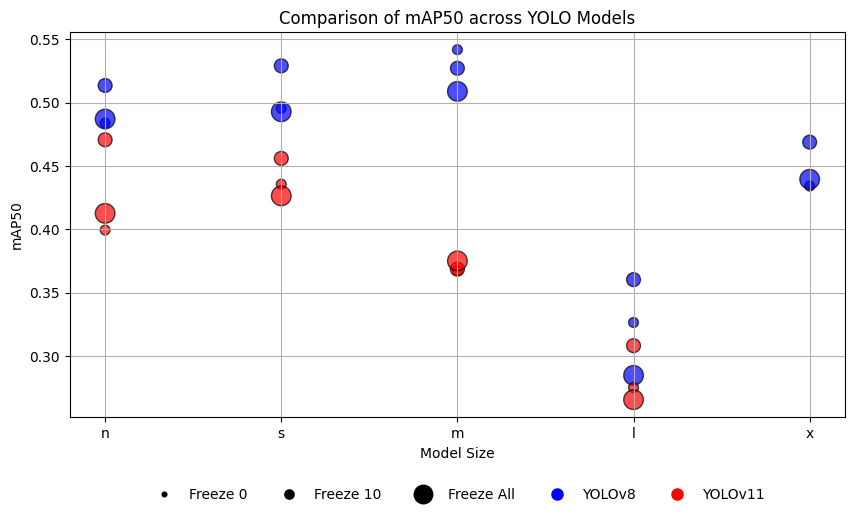

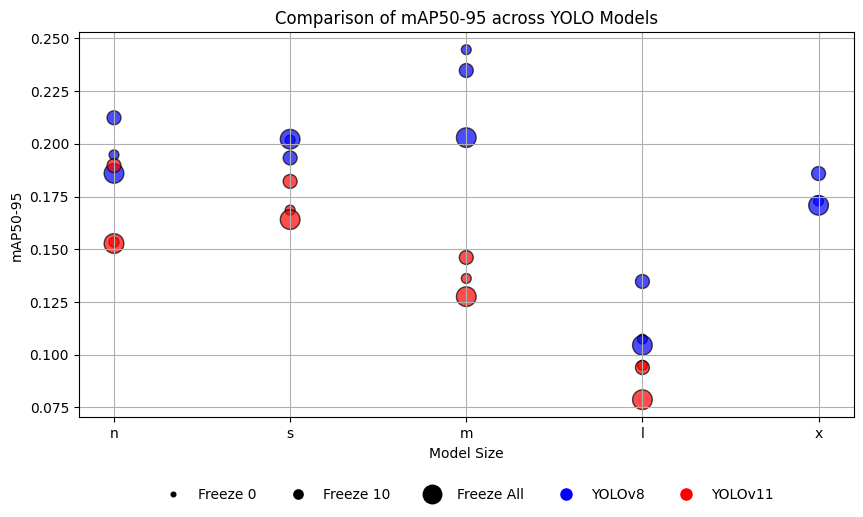

In [ ]:
# Define a mapping for freeze level to marker size
freeze_size_map = {0: 50, 10: 100, "all": 200}
freeze_labels = {0: "Freeze 0", 10: "Freeze 10", "all": "Freeze All"}

# Define color mapping for versions
version_colors = {"YOLOv8": "blue", "YOLOv11": "red"}

plt.figure(figsize=(8, 6))

for metric in ["mAP50", "mAP50-95"]:
    plt.figure(figsize=(10, 5))  # Set figure size

    for ver in versions:
        subset = results_df[results_df["version"] == f"YOLOv{ver}"]

        # Map freeze levels to marker sizes
        marker_sizes = subset["freeze"].map(freeze_size_map)

        # Use scatter plot with color mapping for each YOLO version
        plt.scatter(subset["size"], subset[metric], s=marker_sizes,
                    color=version_colors[f"YOLOv{ver}"], alpha=0.7, edgecolors="black",
                    label=f"YOLOv{ver}")

    plt.xlabel("Model Size")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric} across YOLO Models")
    plt.grid(True)

    # Create a custom legend for marker sizes (freeze levels)
    size_legend_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                      markersize=size / 15, label=label)  # Adjust size for legend scaling
        for freeze, size in freeze_size_map.items()
        for label in [freeze_labels[freeze]]
    ]

    # Create a custom legend for colors (YOLO versions)
    color_legend_handles = [
        mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                      markersize=8, label=ver_label)
        for ver_label, color in version_colors.items()
    ]

    # Combine both legends
    plt.legend(handles=size_legend_handles + color_legend_handles,
               loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5,
               frameon=False)


    plt.show()


The YOLO v8 outperforms the v11 model. Using a model size greater than m (medium) decreases model performance, probably due to the limited amount of training data. The YOLOv8m was the only model, where freezin g0 layers led to the best performance. Otherwise, either freezing the backbone or all layer showed better results. The **best** performing model was the **YOLO v8 medium size and freezing 0 layers** with a mean average precision when the Intersection over Union (IoU) threshold is set to 0.50 (mAP50) of	0.542 and a mean Average Precision across IoU thresholds of 0.50 to 0.95 (mAP50-90) of 0.245.